In [ ]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json
import matplotlib.pyplot as plt
import cv2

from google.colab.patches import cv2_imshow
import numpy as np

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [ ]:
emoji_hunt_object = EmojiHunt() 
transforms = {
  "emoji_transforms": {
    "Add": False,
    "Multiply": False,
    "Cutout": True,
    "CoarseDropout": False,
    "CoarseSaltAndPepper": True,
    "JpegCompression": True,
    "BlendAlpha": False,
    "BlendAlphaRegularGrid": False,
    "GaussianBlur": True,
    "MotionBlur": True,
    "MultiplyHueAndSaturation": False,
    "Grayscale": False,
    "ChangeColorTemperature": False,
    "SigmoidContrast": False,
    "CLAHE": False,
    "Emboss": False,
    "DirectedEdgeDetect": False,
    "Fliplr": False,
    "PiecewiseAffine": False,
    "PerspectiveTransform": False,
    "WithPolarWarping": False,
    "Rot90": True,
    "ElasticTransformation": False,
    "Jigsaw": False
  }
}
emoji_hunt_object.update_config(transforms)

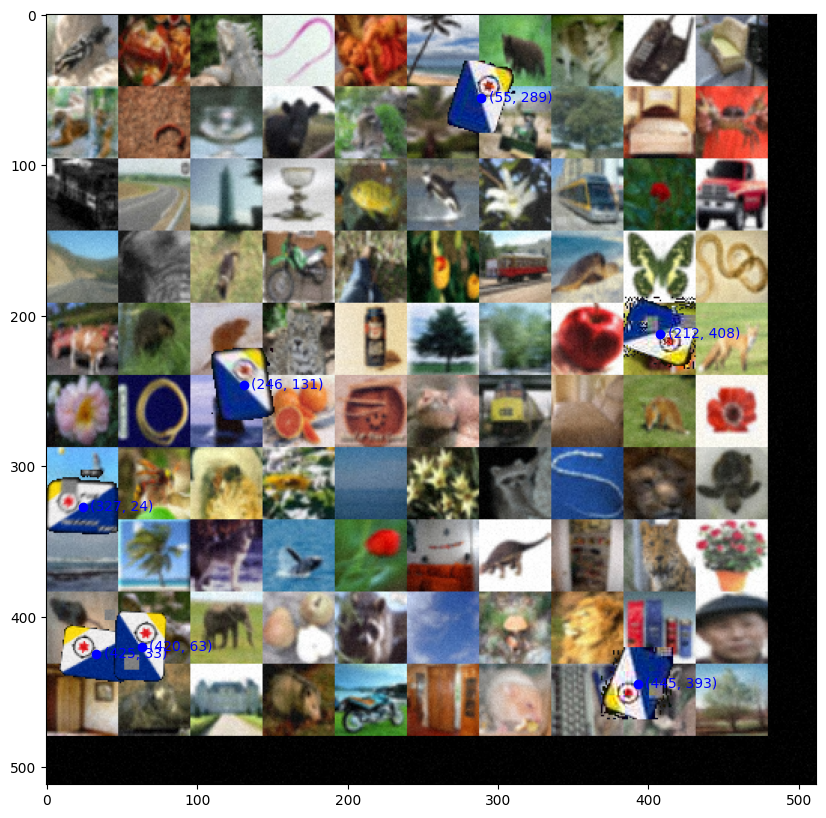

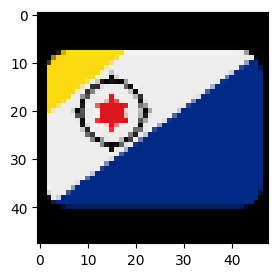

In [ ]:
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
x = [p[0] for p in gt_points]
y = [p[1] for p in gt_points]

plt.scatter(y, x, color="blue")
for p in gt_points:
    plt.annotate(f"{(p[0], p[1])}", (p[1] + 5, p[0] + 2.5), color="blue")

plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def segment_image(image):
  h, w = image.shape[:2]
  sub_h, sub_w = emoji_target.shape[:2]
  stride = 12

  sub_images = []
  for y in range(0, h - sub_h, stride):
    for x in range(0, w - sub_w, stride):
      sub_image = image[y: y + sub_h, x: x + sub_w]
      centre_point = (int( y + (sub_h / 2)), int( x + (sub_w / 2)))
      sub_images.append((sub_image, centre_point))

  return sub_images

In [ ]:
def non_max_suppression(keypoints, radius):
    non_duplicate = {}
    for item in keypoints:
      point = item[1]
      if point not in non_duplicate:
        non_duplicate[point] = item
        
    keypoints = np.array(list(non_duplicate.values()), dtype=object)
    selected_keypoints = []
    
    while len(keypoints) > 0:
      selected_keypoint = keypoints[0]
      selected_keypoints.append(selected_keypoint)

      distances = np.array([np.linalg.norm(np.array(keypoint[1]) - np.array(selected_keypoint[1])) for keypoint in keypoints])

      mask = distances < radius
      keypoints = [keypoints[i] for i in range(len(keypoints)) if not mask[i]]

    return selected_keypoints

In [ ]:
def sift_filter(image, emoji):
  sift = cv2.SIFT_create()
  kp = []

  ref = cv2.cvtColor(emoji.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  kp_ref, desc_ref = sift.detectAndCompute(ref, None)

  filtered = segment_image(image)
  for img in filtered:
    colour_ROI, point = img[0], img[1]
    ROI = cv2.cvtColor(colour_ROI.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    try:
      kp_ROI, desc_ROI = sift.detectAndCompute(ROI, None)
      assert len(kp_ROI) > 0
    except AssertionError:
      continue

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_ref, desc_ROI, k=2)

    good_matches = []

    max_length = max([match[0].distance for match in matches])
    min_length = min([match[0].distance for match in matches])
    factor = np.sqrt(min_length / (min_length + max_length))

    try:
      for m, n in matches:
        if m.distance < factor * n.distance:
          good_matches.append([m])
          kp.append((colour_ROI, point))

    except ValueError:
      pass

  suppressed = non_max_suppression(keypoints=kp, radius=48)

  return suppressed

In [ ]:
def compute_histogram(image):
  gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  hist_size = 256
  hist_range = (0, 256)
  hist = cv2.calcHist([gray], [0], None, [hist_size], hist_range, accumulate=False)

  # Remove contribution of pixels with intensity 0
  hist[0] = 0

  return hist 

def plot_histogram(histogram):
  plt.plot(histogram, color="blue")
  plt.show()

def histogram_similarity(histogram1, histogram2):
  hist1_norm = cv2.normalize(histogram1, histogram1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  hist2_norm = cv2.normalize(histogram2, histogram2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  bhattacharyya = cv2.compareHist(hist1_norm, hist2_norm, cv2.HISTCMP_BHATTACHARYYA)

  return bhattacharyya

In [ ]:
def bhatt_filter(image, emoji):
  emoji_hist = compute_histogram(emoji)
  sub_images = sift_filter(image, emoji)

  bhatts = []
  for item in sub_images:
    sub_image = item[0]
    point = item[1]
    hist = compute_histogram(sub_image)
    score = histogram_similarity(emoji_hist, hist)
    bhatts.append((score, point))

  scores = [item[0] for item in bhatts]
  min_score, mean_score, std_score = np.amin(scores), np.mean(scores), np.std(scores)

  factor = 1.275
  coefficient_variation = std_score / mean_score
  ratio = coefficient_variation * factor
  
  filtered = []
  for i, item in enumerate(bhatts):
    score = item[0]
    point = item[1]
    if np.isclose(score, min_score, rtol=ratio):
      filtered.append(point)

  return filtered

In [ ]:
def result_plot(image, emoji, selected_keypoints):
  x = [p[0] for p in selected_keypoints]
  y = [p[1] for p in selected_keypoints]

  plt.figure(figsize = (10,10))
  imgplot = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  plt.scatter(y, x, color="blue")
  for p in selected_keypoints:
    plt.annotate(f"{(p[0], p[1])}", (p[1] + 5, p[0] + 2.5), color="blue")

  plt.show()
  plt.figure(figsize = (3,3))
  imgplot2 = plt.imshow(cv2.cvtColor(emoji, cv2.COLOR_BGR2RGB))
  plt.show()

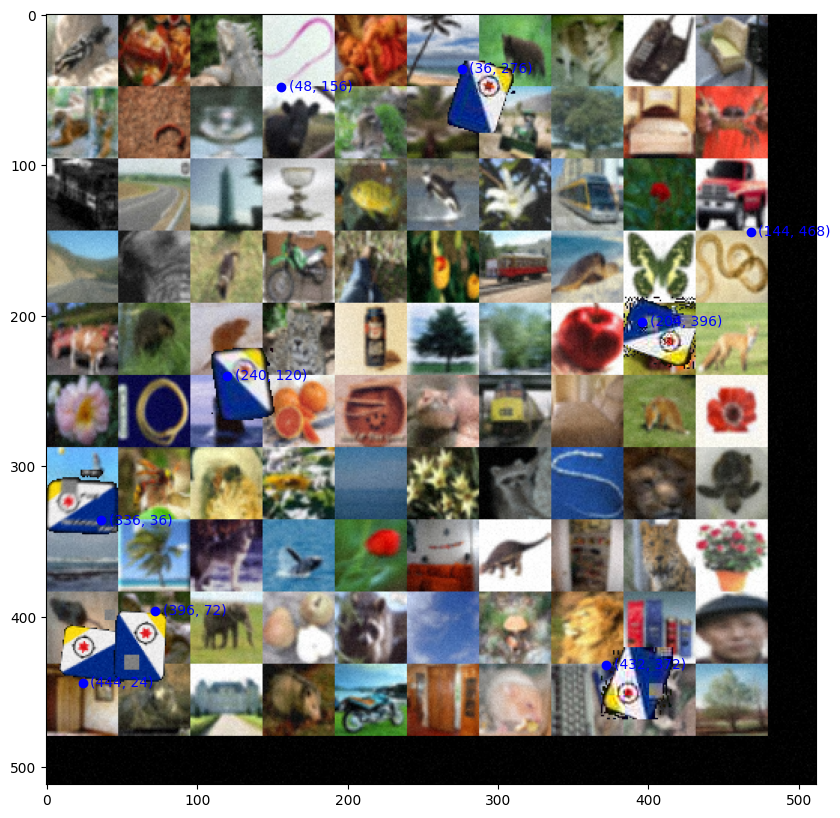

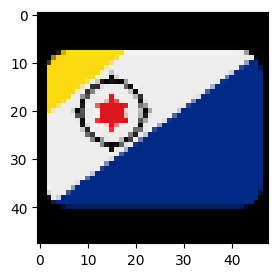

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Cutout
     CoarseSaltAndPepper
     JpegCompression
     GaussianBlur
     MotionBlur
     Rot90
Scores (lower is better)....
    Run 0 -> 212.80713845889687
    Run 1 -> 85.16647255099363
    Run 2 -> 46.09736713912886
    Run 3 -> 468.2706090782479
    Run 4 -> 171.70349181075068
    Run 5 -> 217.3538358355685
    Run 6 -> 169.20607243557458
    Run 7 -> 225.40514084367138
    Run 8 -> 191.60614780191133
    Run 9 -> 28.0178514522438
    Run 10 -> 269.6266685325422
    Run 11 -> 228.6660751520034
    Run 12 -> 169.10573743104857
    Run 13 -> 385.8081727482164
    Run 14 -> 297.0179326250605
    Run 15 -> 184.6736749028079
    Run 16 -> 223.68556558313026
    Run 17 -> 113.2931079749533
    Run 18 -> 102.90013421228639
    Run 19 -> 266.11187420807835
    Run 20 -> 80.08393055208775
    Run 21 -> 148.0174372429911
    Run 22 -> 102.64062235815213
    Run 23 -> 278.9414408118977
    Run 24 -> 146.1181277505795
    Run 25 -> 281.

In [ ]:
# Our score
keypoints = bhatt_filter(test_image, emoji_target)
result_plot(test_image, emoji_target, keypoints)

emoji_hunt_object.offical_test(bhatt_filter, emoji_hunt_object.get_config())